In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sps
import math

from ipywidgets import interact

from ipywidgets import widgets
from tqdm.auto import tqdm

from dataclasses import dataclass
from typing import Union, Callable, Optional
from copy import deepcopy
from scipy.optimize import root_scalar, brentq
from dataclasses import dataclass
from scipy.special import iv
from scipy.stats import bernoulli
from scipy.interpolate import RectBivariateSpline

from vol.vol import Heston

import warnings
from scipy.stats import norm
warnings.filterwarnings("ignore")


@dataclass
class StockOption:
    strike_price:    Union[float, np.ndarray]
    expiration_time: Union[float, np.ndarray]  # in years
    is_call:         bool

@dataclass
class CallStockOption(StockOption):
    def __init__(self, strike_price, expiration_time):
        super().__init__(strike_price, expiration_time, True)

@dataclass
class PutStockOption(StockOption):
    def __init__(self, strike_price, expiration_time):
        super().__init__(strike_price, expiration_time, False)

@dataclass
class HestonParameters:
    kappa:  Union[float, np.ndarray]
    gamma:  Union[float, np.ndarray]
    rho:    Union[float, np.ndarray]
    vbar:   Union[float, np.ndarray]
    v0:     Union[float, np.ndarray]
        
@dataclass
class MarketState:
    stock_price:   Union[float, np.ndarray]
    interest_rate: Union[float, np.ndarray]

Derivatives payoffs:

In [7]:
def european_call(St: np.ndarray, 
                  maturity: float,
                  interest_rate: float,
                  strike: float):
    """Compute the payoff of a European call option.
    Args:
        paths:  The simulated paths.
        strike: The strike price.
    
    Returns:
        The payoff of the European call option.
    """
    DF = np.exp(-interest_rate * maturity)
    return np.maximum(St - strike, 0)*DF

# Heston model

Heston model can be written in following way:

$$dS_t/S_t  = rdt + \sqrt{V_t} dW_1$$

$$dV_t = \kappa (\bar V-V_t)dt + \gamma \sqrt V_t dW_2$$

$$dW_1 dW_2 = \rho dt$$

In [10]:
def get_len_conf_interval(data:             np.ndarray, 
                          confidence_level: float = 0.05):
    """Get the confidence interval length for a given confidence level.
    Args:
        data:             The data to compute the confidence interval for.
        confidence_level: The confidence level to use.
    
    Returns:
        The confidence interval.
    """
    return -2*sps.norm.ppf(confidence_level*0.5) * np.sqrt(np.var(data) / len(data))

def mc_price(payoff:            Callable,
             simulate:          Callable,
             market_state:      MarketState,
             params:            HestonParameters,
             T:                 float = 1.,
             dt:                float = 1e-2,
             absolute_error:    float = 0.05,
             confidence_level:  float = 0.01,
             batch_size:        int   = 2_000,
             time_batch_size:   int   = 10_000,
             MAX_ITER:          int   = 100000,
             **kwargs):
    """A function that performs a Monte-Carlo based pricing of a 
       derivative with a given payoff (possibly, path-dependent)
       under the Heston model.

    Args:
        payoff (Callable):                  payoff function
        simulate (Callable):                simulation engine
        market_state (MarketState):         market state
        params (HestonParameters):          Heston parameters
        T (float, optional):                Contract expiration time. Defaults to 1.. 
        absolute_error (float, optional):   absolute error of the price. Defaults to 0.01 (corresponds to 1 cent). 
        confidence_level (float, optional): confidence level for the price. Defaults to 0.05.
        batch_size (int, optional):         path-batch size. Defaults to 10_000.
        undersample_size (int, optional):   initial guess for the MC simulation error. To be deprecated. Defaults to 1000.
        time_batch_size (int, optional):    pathwise time-batch size. Defaults to 10_000.
    """

    arg1 = {'state':           market_state, #renamed to market_state from state
            'heston_params':   params, 
            'time':            T , 
            'dt':              dt, 
            'time_batch_size': time_batch_size,
            'n_simulations':   batch_size}

    args       = {**arg1, **kwargs}
    iter_count = 5    

    derivative_price_array = np.array([], dtype=np.float64)

    derivative_price_array = np.append(derivative_price_array, np.mean(payoff(simulate(**args)['price']))) 
    derivative_price_array = np.append(derivative_price_array, np.mean(payoff(simulate(**args)['price']))) 
    derivative_price_array = np.append(derivative_price_array, np.mean(payoff(simulate(**args)['price']))) 
    derivative_price_array = np.append(derivative_price_array, np.mean(payoff(simulate(**args)['price']))) 
    derivative_price_array = np.append(derivative_price_array, np.mean(payoff(simulate(**args)['price']))) 

    while get_len_conf_interval(derivative_price_array) > absolute_error and iter_count < MAX_ITER:
        derivative_price_array = np.append(derivative_price_array, np.mean(payoff(simulate(**args)['price']))) 
        iter_count+=1

    print(f"Number of iterations:   {iter_count}")

    return np.mean(derivative_price_array)

## Euler scheme

It can be simulated in discrete time using Euler scheme by selecting a time step $∆t$ starting at $S_0, V_0$:

$$\log s_{i} = \log s_{i-1} + (r - v_{i-1}^+/2)\Delta t+ \sqrt{v_{i-1}^+ \Delta t}(  ρε^1_{i} + \sqrt{1- ρ^2} ε^2_{i})],$$

$$v_{i} =  v_{i-1} + \kappa (\bar V-v_{i-1}^+)\Delta t + \gamma \sqrt{ v_{i-1}^+ \Delta t}ε^1_{i}$$

(section 2.3 eq. 6-7 Andersen (2006) )

In [11]:
def simulate_heston_euler(state:           MarketState,
                          heston_params:   HestonParameters,
                          time:            float = 1.,
                          dt:              float = 1e-2,
                          time_batch_size: int = 10_000,
                          n_simulations:   int = 10_000
                          ) -> dict:
    """Simulation engine for the Heston model using the Euler scheme.

    Args:
        state (MarketState): _description_
        heston_params (HestonParameters): _description_
        time (float, optional): _description_. Defaults to 1..
        dt (float, optional): _description_. Defaults to 1e-2.
        time_batch_size (int, optional): _description_. Defaults to 10_000.
        n_simulations (int, optional): _description_. Defaults to 10_000.

    Raises:
        Error: _description_

    Returns:
        dict: _description_
    """    
    if time<=0:
        raise Error("Time must be bigger than 0")
    
    # initialize market and model parameters
    r, s0 = state.interest_rate, state.stock_price
    
    v0, rho, kappa, vbar, gamma = heston_params.v0, heston_params.rho, heston_params.kappa, \
                                  heston_params.vbar, heston_params.gamma
    
    
    vt = np.zeros(n_simulations)
    vt[:] = v0
    log_st = np.zeros(n_simulations)
    log_st[:] = np.log(s0)
    
    N_T = int(time / dt)
    num_of_time_batch = int(N_T/time_batch_size)
    
    for k in range(num_of_time_batch):
        Z1 = np.random.normal(size=(n_simulations, time_batch_size))
        Z2 = np.random.normal(size=(n_simulations, time_batch_size))
        V = np.zeros([n_simulations, time_batch_size])
        V[:, 0] = vt
        
        logS = np.zeros([n_simulations, time_batch_size])
        logS[:, 0] = log_st

        for i in range(0, time_batch_size-1):
            vmax = np.maximum(V[:, i],0)
            S1 = (r - 0.5 * vmax) * (dt)
            S2 = np.sqrt(vmax*(dt)) * Z1[:, i]
            logS[:, i+1] = logS[:, i] + S1 + S2
            V1 = kappa*(vbar - vmax)*(dt)
            V2 = gamma*np.sqrt(vmax*(dt))*(rho*Z1[:, i]+np.sqrt(1-rho**2)*Z2[:, i])
            V[:, i+1] = V[:, i] + V1 + V2
        vt = V[:, time_batch_size-1]
        log_st = logS[:, time_batch_size-1]

    if N_T > num_of_time_batch*time_batch_size:
        add_batch_time = N_T - num_of_time_batch*time_batch_size

        Z1 = np.random.normal(size=(n_simulations, add_batch_time))
        Z2 = np.random.normal(size=(n_simulations, add_batch_time))
        V = np.zeros([n_simulations, add_batch_time])
        V[:, 0] = vt

        logS = np.zeros([n_simulations, add_batch_time])
        logS[:, 0] = log_st

        for i in range(0, add_batch_time-1):
            vmax=np.maximum(V[:, i],0)
            S1 = (r - 0.5 * vmax) * (dt)
            S2 = np.sqrt(vmax*(dt)) * Z1[:, i]
            logS[:, i+1] = logS[:, i] + S1 + S2
            V1 = kappa*(vbar - vmax)*(dt)
            V2 = gamma*np.sqrt(vmax*(dt))*(rho*Z1[:, i]+np.sqrt(1-rho**2)*Z2[:, i])
            V[:, i+1] = V[:, i] + V1 + V2
        vt = V[:, add_batch_time-1]
        log_st = logS[:, add_batch_time-1]        
        
    return {"price": np.exp(log_st), "volatility": vt}

## Andersen scheme

In [12]:
def simulate_heston_andersen(state: MarketState,
                             heston_params: HestonParameters,
                             time: float = 1.,
                             dt: float = 1e-2,
                             n_simulations: int = 10_000,
                             time_batch_size: int = 10_000,
                             Psi_c: float=1.5,
                             gamma_1: float=0.5) -> dict: 
    """_summary_

    Args:
        state (MarketState): _description_
        heston_params (HestonParameters): _description_
        time (float, optional): _description_. Defaults to 1..
        dt (float, optional): _description_. Defaults to 1e-2.
        n_simulations (int, optional): _description_. Defaults to 10_000.
        time_batch_size (int, optional): _description_. Defaults to 10_000.
        Psi_c (float, optional): _description_. Defaults to 1.5.
        gamma_1 (float, optional): _description_. Defaults to 0.5.

    Raises:
        Error: _description_
        Error: _description_

    Returns:
        dict: _description_
    """    
    
    if Psi_c>2 or Psi_c<1:
        raise Error('1<=Psi_c<=2 ')
    if gamma_1 >1 or gamma_1<0:
        raise Error('0<=gamma_1<=1')
        
    gamma_2 = 1.0 - gamma_1
    
    r, s0 = state.interest_rate, state.stock_price
    v0, rho, kappa, vbar, gamma = heston_params.v0, heston_params.rho, heston_params.kappa, \
                                  heston_params.vbar, heston_params.gamma
    
    
    E = np.exp(-kappa*dt)
    
    K_0 = -(rho*kappa*vbar/gamma)*dt
    K_1 = gamma_1*dt*(rho*kappa/gamma - 0.5) - rho/gamma
    K_2 = gamma_2*dt*(rho*kappa/gamma - 0.5) + rho/gamma
    K_3 = gamma_1*dt*(1.0 - rho**2)
    K_4 = gamma_2*dt*(1.0 - rho**2)
    
    N_T = int(time / dt)
    num_of_time_batch = int(N_T/time_batch_size)
    
    
    vt = np.zeros(n_simulations)
    vt[:] = v0
    log_st = np.zeros(n_simulations)
    log_st[:] = np.log(s0)
    
    mean_St = 0.
    mean_vt = 0.
    
        
    vt[:] = v0
    log_st[:] = np.log(s0)
        
    for k in range(num_of_time_batch):
        V = np.zeros([n_simulations, time_batch_size])
        V[:, 0] = vt

        logS = np.zeros([n_simulations, time_batch_size])
        logS[:, 0] = log_st

        Z = np.random.normal(size=(n_simulations, time_batch_size))


        for i in range(time_batch_size - 1):
            m=vbar+(V[:, i] - vbar)*E
            s_2 = (V[:, i]*(gamma**2)*E/kappa)*(1.0 - E) + (vbar*gamma**2)/(2.0*kappa)*((1-E)**2)

            Psi = s_2/(m**2) # np.power

            cond = np.where(Psi<=Psi_c)
            c = 2/Psi[cond]
            b = c - 1 + np.sqrt(c*(c - 1))
            a = m[cond]/(1+b)
            b=np.sqrt(b)
            Z_V = np.random.normal(size=cond[0].shape[0])
            V[cond, i+1] = a*((b+Z_V)**2)

            cond = np.where(Psi>Psi_c)
            p = (Psi[cond] - 1)/(Psi[cond] + 1)
            beta = (1.0 - p)/m[cond]

            ksi = np.random.binomial(1, 1.0-p, size=cond[0].shape[0])
            eta = np.random.exponential(scale = 1/beta, size=cond[0].shape[0])
            V[cond,i+1]=ksi*eta


            logS[:,i+1] = logS[:,i] + r*dt+K_0 + K_1*V[:,i] + K_2*V[:,i+1] \
                            + np.sqrt(K_3*V[:,i]+K_4*V[:,i+1]) * Z[:,i]

        vt = V[:, time_batch_size-1]
        log_st = logS[:, time_batch_size-1]

    if N_T > num_of_time_batch*time_batch_size:

        add_batch_time = N_T - num_of_time_batch*time_batch_size

        V = np.zeros([n_simulations, add_batch_time])
        V[:, 0] = vt
        logS = np.zeros([n_simulations, add_batch_time])
        logS[:, 0] = log_st
        
        Z = np.random.normal(size=(n_simulations, add_batch_time))

        for i in range(add_batch_time - 1):
            m=vbar+(V[:, i] - vbar)*E
            s_2 = (V[:, i]*(gamma**2)*E/kappa)*(1.0 - E) + (vbar*gamma**2)/(2.0*kappa)*((1-E)**2)

            Psi = s_2/(m**2)

            cond = np.where(Psi<=Psi_c)
            c = 2/Psi[cond]
            b = c - 1 + np.sqrt(c*(c - 1))
            a = m[cond]/(1+b)
            b=np.sqrt(b)
            Z_V = np.random.normal(size=cond[0].shape[0])
            V[cond, i+1] = a*((b+Z_V)**2)

            cond = np.where(Psi>Psi_c)
            p = (Psi[cond] - 1)/(Psi[cond] + 1)
            beta = (1.0 - p)/m[cond]

            ksi = np.random.binomial(1, 1.0-p, size=cond[0].shape[0])
            eta = np.random.exponential(scale = 1/beta, size=cond[0].shape[0])
            V[cond,i+1]=ksi*eta


            logS[:,i+1] = logS[:,i] + r*dt+K_0 + K_1*V[:,i] + K_2*V[:,i+1] \
                            + np.sqrt(K_3*V[:,i]+K_4*V[:,i+1]) * Z[:,i]

        vt = V[:, add_batch_time-1]
        log_st = logS[:, add_batch_time-1]
            
            
        
    #put the calculated values into the dictionary
    simulated_paths = {"price": np.exp(log_st), "volatility": vt}
    return simulated_paths

## Broadie - Kaya scheme

In [27]:
def cir_chi_sq_sample(heston_params: HestonParameters,
                      dt:            float,
                      v_i:           np.array,
                      n_simulations: int):
    """Samples chi_squared statistics for v_{i+1} conditional on 
       v_i and parameters of Hestom model. 
        
    Args:
        heston_params (HestonParameters): parameters of Heston model
        dt (float): time step 
        v_i: current volatility value
        n_simulations (int): number of simulations.
        
    Returns:
        np.array: sampled chi_squared statistics 
    """
    kappa, vbar, gamma = heston_params.kappa, heston_params.vbar, heston_params.gamma
    
    barkappa=v_i*(4*kappa*np.exp(-kappa*dt))/(gamma**2 * (1 - np.exp(-kappa*dt)))
    d=(4*kappa*vbar)/(gamma**2)
    c=((gamma**2)/(4*kappa))*(1-np.exp(-kappa*dt))
    
    return  c*np.random.noncentral_chisquare(size = n_simulations, df   = d, nonc = barkappa)


def Phi(a:             Union[float, np.ndarray], 
        V:             Union[float, np.ndarray],
        time:          Union[float, np.ndarray],
        heston_params: HestonParameters
        ) -> np.ndarray:
    
    
    v0, rho, kappa, vbar, gamma = heston_params.v0, heston_params.rho, heston_params.kappa, \
                                        heston_params.vbar, heston_params.gamma
    dt = time[1::]-time[:-1:]
    
    A=np.array(a)
    gamma_a = np.sqrt(kappa**2 - 2*gamma**2*1j*A).reshape(1,1,len(A)).T
    
    E1 = np.exp(-kappa*dt)
    E2 = np.exp(-gamma_a * dt)
        
    P1 = ((1.0-E1)*gamma_a/(kappa*(1.0-E2)))*np.exp(-0.5*(gamma_a - kappa)*dt)
    
    P2_2 = kappa * (1.0 + E1)/(1.0 - E1) - gamma_a*(1.0+E2)/(1-E2)
    P2 = np.exp( (V[:,1::]+V[:,:-1:])/(gamma_a**2) * P2_2 )
    
    P3_1 = np.sqrt(V[:,1::]*V[:,:-1:])*4*gamma_a * np.exp(-0.5*gamma_a*dt) /(gamma**2 * (1.0 - E2))
    P3_2 = np.sqrt(V[:,1::]*V[:,:-1:])*4*kappa*np.exp(-0.5*kappa*dt)/(gamma**2 * (1 - E1))
    d=(4*kappa*vbar)/(gamma**2)
    P3 = iv(0.5*d - 1, P3_1)/iv(0.5*d - 1, P3_2)
    
    return P1*P2*P3

def Pr(V:             np.ndarray, 
       time:          np.ndarray,
       X:             Union[np.ndarray, float],
       heston_params: HestonParameters,
       h:             float=1e-2, 
       eps:           float=1e-2
       ) -> np.ndarray:
    
    x=np.array(X)
    P=h*x/np.pi
    S = 0.0
    j = 1
    while(True):
        Sin=np.sin(h*j*x)/j
        Phi_hj=Phi(h*j, V, time, heston_params)
        S+=Sin.reshape(1,1,len(x)).T * Phi_hj[0]
        if np.all(Phi_hj[0]<np.pi*eps*j/2.0):
            break
        j=j+1
    
    S=S*2.0/np.pi
    return P+S

def IV(V:             np.ndarray, 
       time:          np.ndarray,
       heston_params: HestonParameters,
       h:             float=1e-2, 
       eps:           float=1e-2
       ) -> np.ndarray:
    
    U=np.random.uniform(size=(V.shape[0], V.shape[1] - 1))
    
    def f(x,i,j):
        P=Pr(V, time, x, heston_params, h, eps)
        return (P-U)[0][i,j]
    
    IVar = np.zeros((V.shape[0], V.shape[1] - 1))
    
    for i in range(IVar.shape[0]):
        for j in range(IVar.shape[1]):     
            IVar[i,j]=root_scalar(f, args=(i,j), x0=0.5, method='newton')
    return IVar

## Tests

In [2]:
heston_parameters = HestonParameters(kappa = 1.3125, gamma = 0.7125, 
                                     rho = -0.3937, vbar = 0.0641, 
                                     v0 = 0.3)

state = MarketState(stock_price = 100., interest_rate = 0.)

params = heston_parameters
model = Heston(state.stock_price, heston_parameters.v0, heston_parameters.kappa, heston_parameters.vbar, heston_parameters.gamma, heston_parameters.rho, state.interest_rate)
kwargs = {}

In [3]:
def get_payoff(maturity: float,
               strike: float,
               interest_rate: float = 0.):
    def payoff(St: np.ndarray):
        DF = np.exp(-interest_rate * maturity)
        return np.maximum(St - strike, 0)*DF

    return payoff

### At the money

In [4]:
strike = 100.
T = 1.
payoff = get_payoff(T, strike, state.interest_rate)

In [5]:
theory = model.call_price(T, strike)
print(theory)

16.173896895486777


In [211]:
np.random.seed(42)
euler    = mc_price(dt = 1e-2, market_state = state, payoff = payoff, simulate = simulate_heston_euler, params = params, T = T, **kwargs)
print(euler)

Number of iterations: 2452
16.156542307905806


In [212]:
np.random.seed(42)
andersen = mc_price(dt = 5e-2, market_state = state, payoff = payoff, simulate = simulate_heston_andersen, params = params, T = T, **kwargs)
print(andersen)

Number of iterations: 2373
15.933060942727494


### Out of the money

In [213]:
strike = 500.
payoff = get_payoff(T, strike, state.interest_rate)

In [214]:
model.call_price(T, strike)

0.004306995667860747

In [215]:
np.random.seed(42)
euler    = mc_price(dt = 1e-2, market_state = state, payoff = payoff, simulate = simulate_heston_euler, params = params, T = T, **kwargs)
print(euler)

Number of iterations: 5
0.025373192988795527


In [216]:
np.random.seed(42)
andersen = mc_price(dt = 1e-2, market_state = state, payoff = payoff, simulate = simulate_heston_andersen, params = params, T = T, **kwargs)
print(andersen)

Number of iterations: 16
0.014466815342029883


### Implied volatility

In [38]:
def d_1(q,T,S,K,r):
    denom=1/(q*np.sqrt(T))
    log=np.log(S/K)
    s2=T*(r+q*q/2)
    return denom*(log+s2)

def d_2(q,T,S,K,r):
    denom=1/(q*np.sqrt(T))
    log=np.log(S/K)
    s2=T*(r-q*q/2)
    
    return denom*(log+s2)

def calc_iv(option: CallStockOption, state: MarketState, option_price: float):
    
    T=option.expiration_time
    K=option.strike_price
    S=state.stock_price
    r=state.interest_rate    
    N=sps.norm()
    
    
    def f(q):
        d1=d_1(q,T,S,K,r)
        d2=d_2(q,T,S,K,r)
        return S*N.cdf(d1)-K*(np.exp(-r*T))*N.cdf(d2)-option_price
    
    def fprime(q):
        d1=d_1(q,T,S,K,r)
        return S*sps.norm().pdf(d1)*np.sqrt(T)
    
    sol = root_scalar(f, x0=0.5, fprime=fprime, method='newton')
    return sol.root



In [41]:
strikes = np.arange(80, 120, 2)
strikes

array([ 80,  82,  84,  86,  88,  90,  92,  94,  96,  98, 100, 102, 104,
       106, 108, 110, 112, 114, 116, 118])

In [42]:
call_price = np.array([30.096826945107107,
 28.86569299569351,
 27.627749990421822,
 26.468755491540694,
 25.31876428557471,
 24.24782290614315,
 23.16942316862601,
 22.12935496069162,
 21.079816460198398,
 20.20119494244462,
 19.288858679686502,
 18.392107111749084,
 17.50127598061397,
 16.701957005015792,
 15.90122188123928,
 15.14196593075513,
 14.43621999411162,
 13.722786552930495,
 13.069519364876335,
 12.47747576375882])

In [43]:
IV = np.empty_like(call_price)

for j in range(len(call_price)):
        IV[j] = calc_iv(option=CallStockOption(strikes[j], T), 
                           state=state, 
                           option_price=call_price[j])

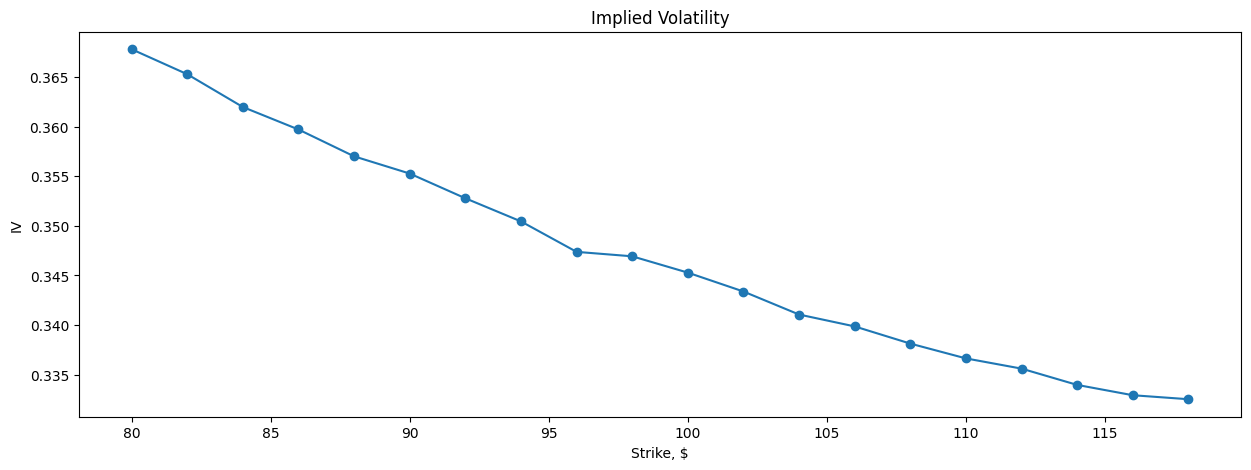

In [44]:
_, ax = plt.subplots(figsize=(15, 5))

ax.plot(strikes, IV, "o-")
# ax.legend()
ax.set_xlabel("Strike, $")
ax.set_ylabel("IV")
ax.set_title("Implied Volatility")
plt.show()

In [45]:
model = Heston(state.stock_price, heston_parameters.v0, heston_parameters.kappa, 
                         heston_parameters.vbar, heston_parameters.gamma, heston_parameters.rho, state.interest_rate)

In [46]:
call_price = np.zeros(20)

for j in range(20):
    call_price[j] = model.call_price(2., strikes[j])

In [47]:
IV = np.empty_like(call_price)

for j in range(len(call_price)):
        IV[j] = calc_iv(option=CallStockOption(strikes[j], T), 
                           state=state, 
                           option_price=call_price[j])

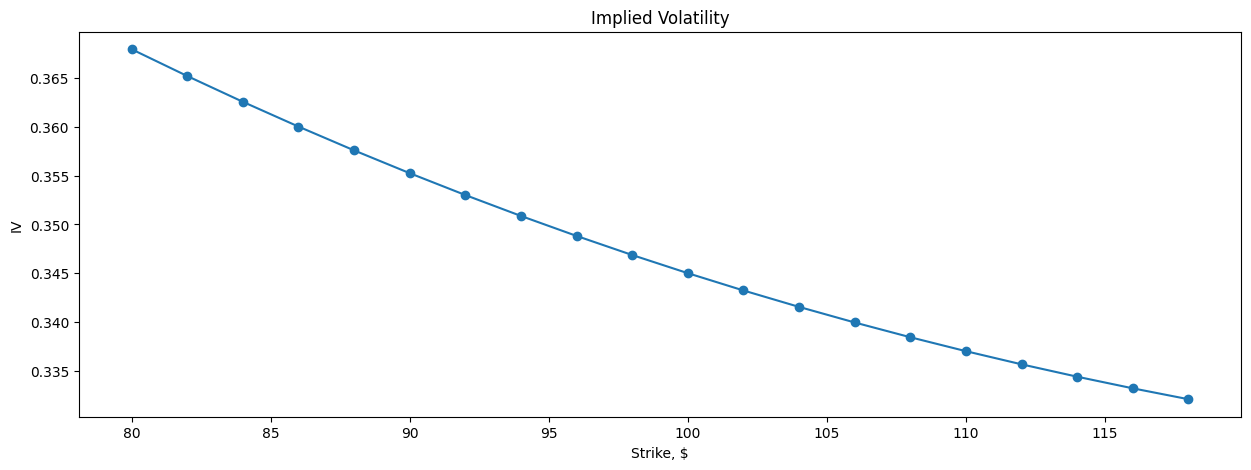

In [48]:
_, ax = plt.subplots(figsize=(15, 5))

ax.plot(strikes, IV, "o-")
# ax.legend()
ax.set_xlabel("Strike, $")
ax.set_ylabel("IV")
ax.set_title("Implied Volatility")
plt.show()